# Revised Project Proposal

---
Students: 

- Tailine, DC427182
- Zhong Wanyi, DC229805

In [9]:
# importing libraries
import pandas as pd
import numpy as np

In [10]:
# reading the data from the url
crime_dataset = pd.read_csv('Crime_Data_from_2020_to_Present.csv')
crime_dataset.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,220614831,08/18/2022 12:00:00 AM,08/17/2020 12:00:00 AM,1200,6,Hollywood,666,2,354,THEFT OF IDENTITY,...,IC,Invest Cont,354.0,NaN,NaN,NaN,1900 TRANSIENT,NaN,34.0944,-118.3277


In [11]:
# dataset variables
crime_dataset.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')

In [12]:
crime_dataset['Vict Sex'].value_counts()

Vict Sex
M    396769
F    352750
X     94561
H       112
-         1
Name: count, dtype: int64

In [13]:
crime_dataset['Vict Age'].value_counts().sort_index()

Vict Age
-4           3
-3           5
-2          27
-1          96
 0      259601
         ...  
 96         95
 97         72
 98         71
 99        352
 120         1
Name: count, Length: 104, dtype: int64

In [14]:
# cleaning data
# age should be greater than 0 and can be categorized
crime_dataset = crime_dataset[crime_dataset['Vict Age'] > 0]
labels=["0-17", "18-25", "26-34", "35-44", "45-54", "55-64", "65+"]
bins=[0, 17, 25, 34, 44, 54, 64, np.inf]

crime_dataset["victim_ages"] = pd.cut(crime_dataset["Vict Age"], labels= labels, bins = bins)
crime_dataset[["Vict Age", "victim_ages"]].head()

# filter only victim sex == F or M
crime_dataset = crime_dataset[crime_dataset['Vict Sex'].isin(['F', 'M'])]

In [15]:
# checking the number of crimes
crime_dataset['Crm Cd Desc'].value_counts().size

138

In [16]:
# converting the date to datetime
crime_dataset['DATE OCC'] = pd.to_datetime(crime_dataset['DATE OCC'], errors='coerce')
crime_dataset = crime_dataset.dropna(subset=['DATE OCC'])

C:\Users\User\AppData\Local\Temp\ipykernel_15968\2366787212.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crime_dataset['DATE OCC'] = pd.to_datetime(crime_dataset['DATE OCC'], errors='coerce')


In [17]:
# define broader categories for crimes
def categorize_crime(crime_description):
    if'ASSAULT' in crime_description or 'ROBBERY' in crime_description or 'HOMICIDE' in crime_description:
        return 'Violent Crime'
    elif 'BURGLARY' in crime_description or 'THEFT' in crime_description or 'VANDALISM' in crime_description or 'STOLEN' in crime_description:
        return 'Property Crime'
    else:
        return 'Other'

crime_dataset['category'] = crime_dataset['Crm Cd Desc'].apply(categorize_crime)
crime_dataset['category'].value_counts()

category
Property Crime    381063
Violent Crime     222237
Other             109424
Name: count, dtype: int64

In [18]:
# dividing the data into two periods (COVID and Post-COVID)
covid_start = '2020-03-01'
covid_end = '2021-06-30'

crime_dataset['period'] = crime_dataset['DATE OCC'].apply(
    lambda x: 'COVID' if covid_start <= x.strftime('%Y-%m-%d') <= covid_end else 'pre|post COVID')
    
covid_data = crime_dataset[crime_dataset['period'] == 'COVID']
post_covid_data = crime_dataset[crime_dataset['period'] == 'pre|post COVID']

print('Covid data:',covid_data.shape)
print('Pre|Post Covid data:', post_covid_data.shape)

Covid data: (195892, 31)
Pre|Post Covid data: (516832, 31)


In [19]:
# create a function that groups by x and the category 

def group_by_category(x):
    return crime_dataset.groupby([x, 'category']).size().unstack().fillna(0)

# now for percentage of crimes by category
def percentage_by_category(x):
    return group_by_category(x).apply(lambda x: x / x.sum(), axis=1)

In [20]:
# create a function that plots the percentage of crimes by category and period

def plot_crime_by_category_pct(x):
    crime_by_category = percentage_by_category(x)
    ax = crime_by_category.plot(kind='bar', alpha=0.8, figsize=(10, 6))
    ax.set_ylabel('Percentage')
    ax.set_title('Percentage of crimes by category')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.legend(title='Category', title_fontsize='13', fontsize='11', loc='upper left')
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2, 
                    height,
                    f'{height:.0%}', 
                    ha='center',
                    va='bottom',
                    fontsize=10)

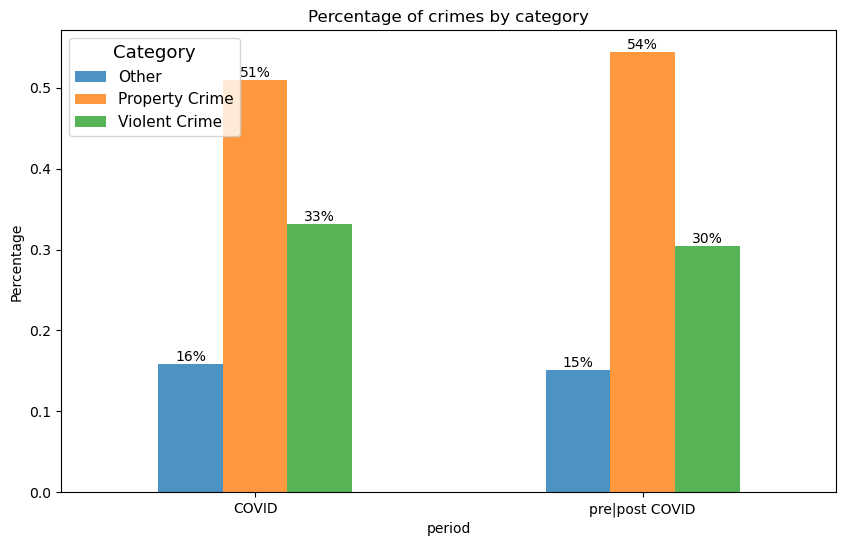

In [21]:
plot_crime_by_category_pct('period')

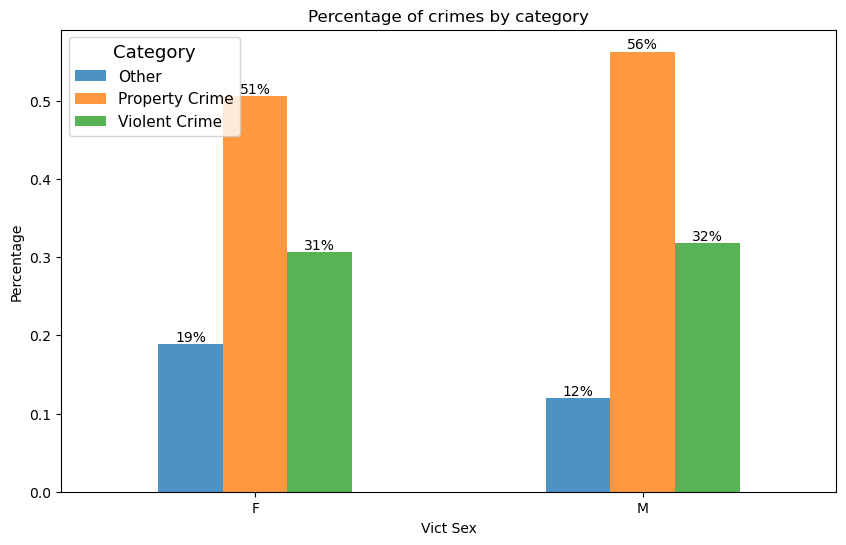

In [22]:
plot_crime_by_category_pct('Vict Sex')

C:\Users\User\AppData\Local\Temp\ipykernel_15968\1976509316.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return crime_dataset.groupby([x, 'category']).size().unstack().fillna(0)


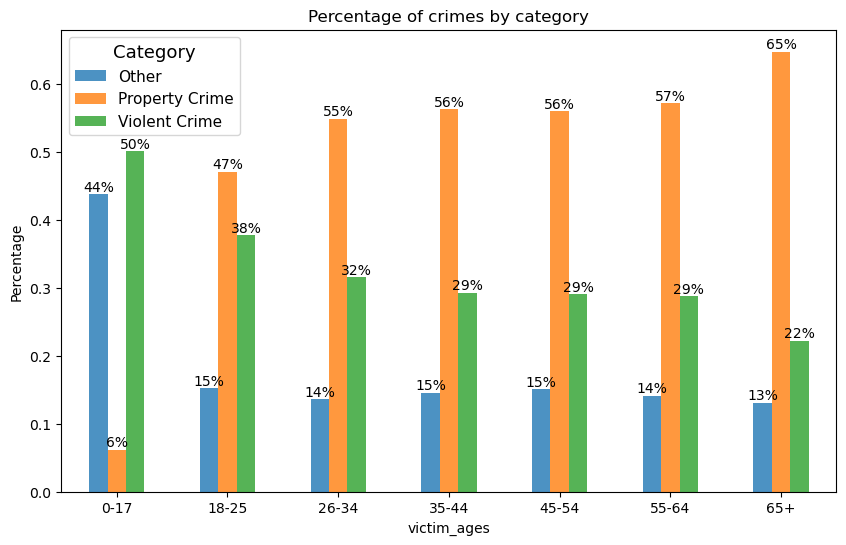

In [23]:
plot_crime_by_category_pct('victim_ages')

In [24]:
# Create a binary variables
crime_dataset['Is Homicide'] = crime_dataset['Crm Cd Desc'].apply(lambda x: 1 if x == 'CRIMINAL HOMICIDE' else 0)
crime_dataset['Is Homicide'].value_counts()

Is Homicide
0    711186
1      1538
Name: count, dtype: int64

In [25]:
homicides = crime_dataset[crime_dataset['Is Homicide'] == 1]
homicides.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,victim_ages,category,period,Is Homicide
5002,200100785,05/16/2020 12:00:00 AM,2020-05-15,1945,1,Central,142,1,110,CRIMINAL HOMICIDE,...,NaN,NaN,300 S OLIVE ST,NaN,34.0523,-118.2502,55-64,Violent Crime,COVID,1
6508,201314412,07/24/2020 12:00:00 AM,2020-07-23,2145,13,Newton,1367,1,110,CRIMINAL HOMICIDE,...,NaN,NaN,1700 E 52ND ST,NaN,33.9954,-118.2432,26-34,Violent Crime,COVID,1
7834,201214818,06/17/2020 12:00:00 AM,2020-06-17,50,12,77th Street,1266,1,110,CRIMINAL HOMICIDE,...,NaN,NaN,500 W 81ST ST,NaN,33.9655,-118.2827,18-25,Violent Crime,COVID,1
7882,201113525,09/12/2020 12:00:00 AM,2020-09-12,1200,11,Northeast,1137,1,110,CRIMINAL HOMICIDE,...,NaN,NaN,600 N AVENUE 50,NaN,34.1109,-118.2016,35-44,Violent Crime,COVID,1
8416,201319978,11/15/2020 12:00:00 AM,2020-11-15,150,13,Newton,1331,1,110,CRIMINAL HOMICIDE,...,NaN,NaN,3100 S HILL ST,NaN,34.0211,-118.2740,26-34,Violent Crime,COVID,1


In [26]:
# mean age of the victims
overall_mean = homicides['Vict Age'].mean()
mean_victim_ages_by_gender = homicides.groupby(['Crm Cd Desc', 'Vict Sex'])['Vict Age'].mean().reset_index()

mean_victim_ages_by_gender['Overall Mean Victim Age'] = overall_mean

print(mean_victim_ages_by_gender.sort_values(by=['Crm Cd Desc', 'Vict Sex']).to_markdown(index=False))

| Crm Cd Desc       | Vict Sex   |   Vict Age |   Overall Mean Victim Age |
|:------------------|:-----------|-----------:|--------------------------:|
| CRIMINAL HOMICIDE | F          |    38.7379 |                   37.3687 |
| CRIMINAL HOMICIDE | M          |    37.1569 |                   37.3687 |


In [27]:
# median age of the victims
overall_median = homicides['Vict Age'].median()
median_victim_ages_by_gender = homicides.groupby(['Crm Cd Desc', 'Vict Sex'])['Vict Age'].median().reset_index()

median_victim_ages_by_gender['Overall Median Victim Age'] = overall_median

print(median_victim_ages_by_gender.sort_values(by=['Crm Cd Desc', 'Vict Sex']).to_markdown(index=False))

| Crm Cd Desc       | Vict Sex   |   Vict Age |   Overall Median Victim Age |
|:------------------|:-----------|-----------:|----------------------------:|
| CRIMINAL HOMICIDE | F          |         35 |                        34.5 |
| CRIMINAL HOMICIDE | M          |         34 |                        34.5 |


In [28]:
# correlation between the crime being a homicide and the age of the victims
correlation_age = crime_dataset['Is Homicide'].corr(crime_dataset['Vict Age'])
print(f"Correlation between crime being a homicide and victim age: {correlation_age}")

Correlation between crime being a homicide and victim age: -0.007096097740188022


In [29]:
# correlation between the crime being a homicide and the gender of the victims
crime_dataset['Is Homicide'] = crime_dataset['Crm Cd Desc'].apply(lambda x: 1 if x == 'CRIMINAL HOMICIDE' else 0)
crime_dataset = crime_dataset[crime_dataset["Vict Sex"].isin(["M", "F"])]
crime_dataset['Vict Sex Encoded'] = crime_dataset['Vict Sex'].apply(lambda x: 1 if x == 'M' else 0)
correlation_gender = crime_dataset['Is Homicide'].corr(crime_dataset['Vict Sex Encoded'])
print(f"Correlation between crime being a homicide and victim gender: {correlation_gender}")

Correlation between crime being a homicide and victim gender: 0.03307853721475881


In [30]:
# create funciton that plots the percentage of homicides by x
# category is not needed here since all homicides are violent crimes

def plot_homicides_by(x):
    homicides_by = homicides.groupby([x]).size()
    homicides_by = homicides_by / homicides_by.sum()
    ax = homicides_by.plot(kind='bar', alpha=0.8, figsize=(10, 6))
    ax.set_ylabel('Percentage')
    ax.set_title('Percentage of homicides by ' + x)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2, 
                    height,
                    f'{height:.0%}', 
                    ha='center',
                    va='bottom',
                    fontsize=10)


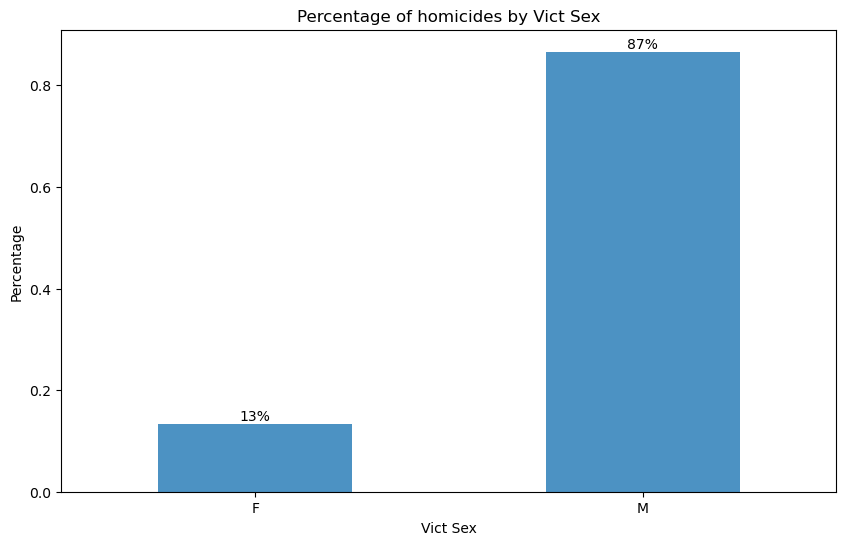

In [31]:
plot_homicides_by('Vict Sex')

C:\Users\User\AppData\Local\Temp\ipykernel_15968\1238174418.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  homicides_by = homicides.groupby([x]).size()


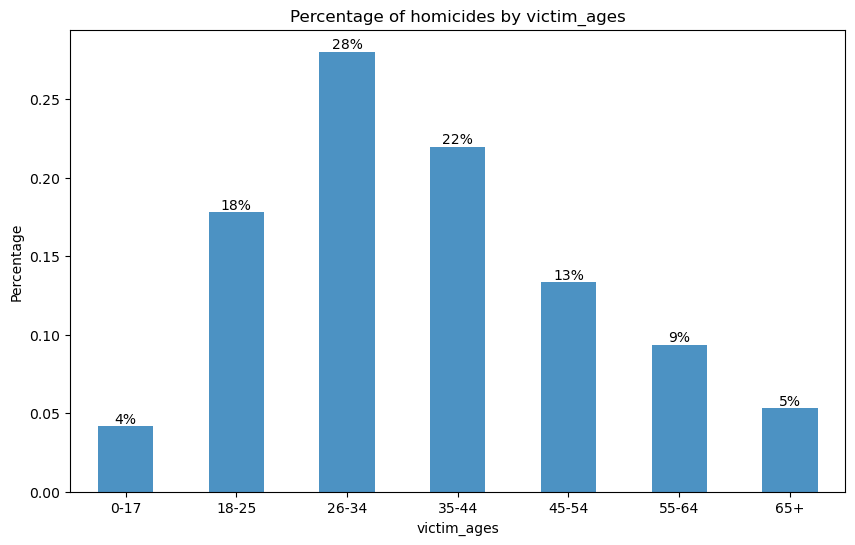

In [32]:
plot_homicides_by('victim_ages')

In [33]:
# create a line plot of the number of homicides by date and x with smoothness

def plot_homicides_by_date(x):
    homicides_by_date = homicides.groupby(['DATE OCC', x]).size().unstack().fillna(0)
    homicides_by_date_smooth = homicides_by_date.rolling(window=90, min_periods=1).mean()  # 90-day rolling mean for smoothness
    ax = homicides_by_date_smooth.plot(kind='line', alpha=0.8, figsize=(10, 6))
    ax.set_ylabel('Number of homicides')
    ax.set_title('Number of homicides by ' + x)
    ax.legend(title='Category', title_fontsize='13', fontsize='11', loc='upper left')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


C:\Users\User\AppData\Local\Temp\ipykernel_15968\4072736601.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


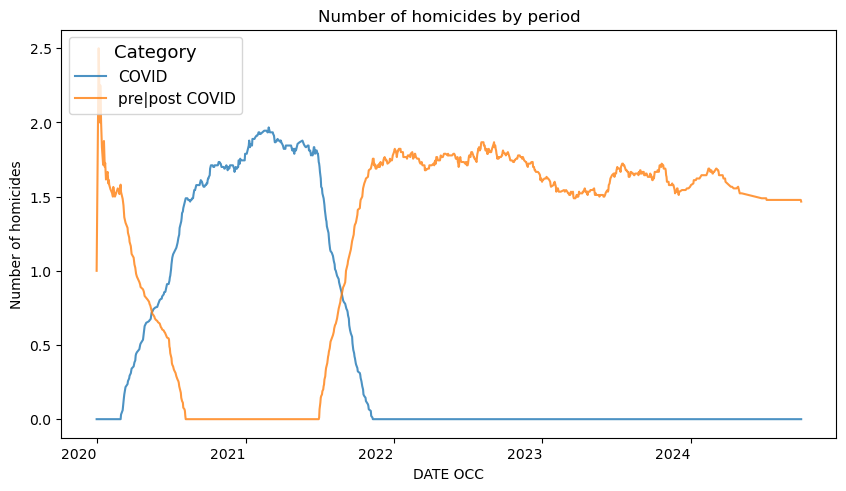

In [34]:
plot_homicides_by_date('period')

C:\Users\User\AppData\Local\Temp\ipykernel_15968\4072736601.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


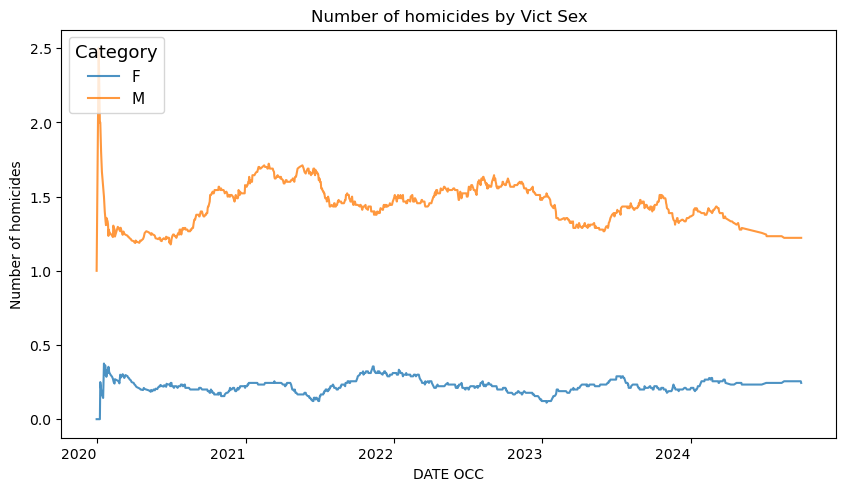

In [35]:
plot_homicides_by_date('Vict Sex')

C:\Users\User\AppData\Local\Temp\ipykernel_15968\4072736601.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  homicides_by_date = homicides.groupby(['DATE OCC', x]).size().unstack().fillna(0)
C:\Users\User\AppData\Local\Temp\ipykernel_15968\4072736601.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


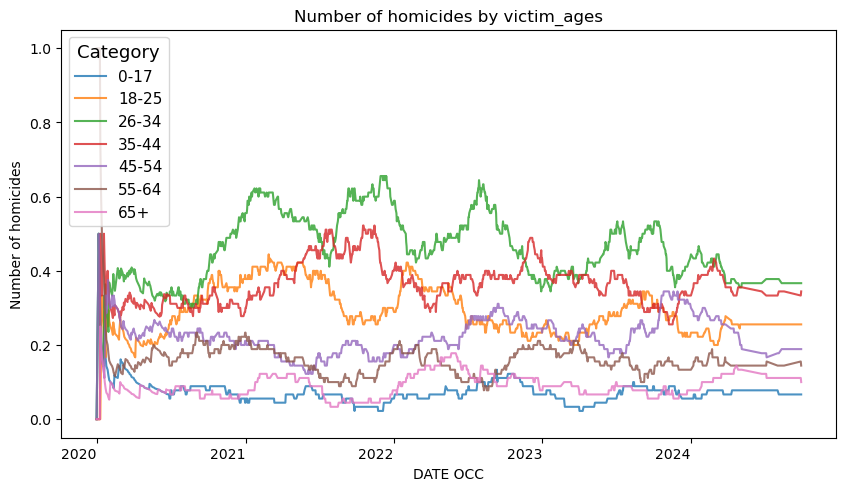

In [36]:
plot_homicides_by_date('victim_ages')